---

OASIS-1 es una valiosa colección de datos de resonancia magnética (RM) transversal que abarca a **416 sujetos** de entre **18 y 96 años**. Cada participante se sometió a entre tres y cuatro exploraciones de RM ponderadas en T1 durante una única sesión. Es importante destacar que todos los sujetos eran diestros, e incluían tanto a hombres como a mujeres. Un subconjunto significativo de esta cohorte, **100 sujetos mayores de 60 años**, fueron diagnosticados clínicamente con la enfermedad de Alzheimer en una fase de muy leve a moderada. Además, la recopilación incluye un conjunto de datos de fiabilidad de 20 sujetos sin demencia, a quienes se les realizaron imágenes dentro de los 90 días posteriores a su visita inicial, lo que añade una capa de robustez al estudio. 💪

El propósito central de OASIS-1 es proporcionar un conjunto de datos exhaustivo de RM transversal que cubra un amplio espectro de edades, desde adultos jóvenes y de mediana edad hasta personas mayores con y sin demencia. Estos datos son increíblemente valiosos para la investigación en neurociencia, especialmente para estudiar cómo el cerebro envejece de forma normal y cómo se ve afectado por enfermedades neurodegenerativas como el **Alzheimer**. Permiten a los investigadores analizar y comprender los cambios estructurales en el cerebro a lo largo de un amplio rango de edades y bajo diversas condiciones clínicas. 💡

---

Para analizar en profundidad estos datos de RM, una herramienta fundamental en la comunidad de la neurociencia es **FreeSurfer**. Se trata de un potente paquete de software de **código abierto** diseñado específicamente para procesar y analizar imágenes de resonancia magnética del cerebro. FreeSurfer ofrece una serie de capacidades de análisis automatizado que son esenciales para desentrañar la información contenida en conjuntos de datos como OASIS-1.

Entre sus funciones clave se incluyen:

* **Segmentación volumétrica:** Identifica y cuantifica el volumen de diferentes estructuras cerebrales como la sustancia gris, la sustancia blanca y el líquido cefalorraquídeo, así como subregiones específicas como el hipocampo o la amígdala. 🧠💧
* **Reconstrucción de la superficie cortical:** Crea modelos 3D detallados de la corteza cerebral que permiten medir métricas críticas como el grosor cortical, el área de la superficie y la curvatura del cerebro. Estas mediciones son cruciales para entender cómo evoluciona el cerebro con la edad y cómo se altera en diversas patologías neurológicas. 📈
* **Análisis estadístico:** Facilita el análisis estadístico, lo que permite a los investigadores realizar comparaciones significativas entre diferentes grupos de sujetos (por ejemplo, pacientes con Alzheimer versus controles sanos) o seguir los cambios en un mismo individuo a lo largo del tiempo. 📊

Al aplicar FreeSurfer a los escaneos de RM ponderados en T1 de OASIS-1, los investigadores pueden extraer medidas anatómicas cerebrales detalladas, como los cambios en el volumen de la materia gris en regiones específicas o el adelgazamiento de la corteza, que son indicadores vitales en el estudio de enfermedades como el Alzheimer. De hecho, la estrecha relación entre estos datos y las herramientas de análisis como FreeSurfer es tan fuerte que algunos conjuntos de datos OASIS más recientes, como OASIS-3, incluso ofrecen directamente las salidas preprocesadas con FreeSurfer para su descarga, simplificando aún más la investigación.✨

Por ese mitivo hemos decidido usar como primer acercamiento OASIS-1.

In [16]:
import nibabel as nib
import scipy.ndimage as ndi 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import io

In [3]:
crossSectional = pd.read_excel("oasis_cross-sectional.xlsx")
ND = crossSectional[crossSectional["CDR"] == 0];VM = crossSectional[crossSectional["CDR"] == 0.5];MiD = crossSectional[crossSectional["CDR"] == 1];MoD = crossSectional[crossSectional["CDR"] == 2]

In [85]:
img = nib.load("/home/nicolas/Documentos/gliara/OASIS/1/OAS1_0010_MR1/mri/norm.mgz") # norm plis
data = img.get_fdata()

In [86]:
nx, ny, nz = data.shape
print(f"Dimensiones del volumen: {nx} (X) x {ny} (Y) x {nz} (Z)")
print(f"Tipo de datos (dtype): {data.dtype}")

Dimensiones del volumen: 256 (X) x 256 (Y) x 256 (Z)
Tipo de datos (dtype): float64


# Visualizar Neuroimagen
### Funcion para visualizar nib

In [ ]:
def plot_slices(data):
    plt.figure(figsize=(15, 5))

    # Vista Axial (plano XY)
    slice_z_index = nz // 2
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(data[:, :, slice_z_index].T, cmap='gray', origin='lower')
    ax1.set_title(f'Vista Axial (Z={slice_z_index})')
    ax1.axis('off')

    # Vista Coronal (plano XZ)
    slice_y_index = ny // 2
    ax2 = plt.subplot(1, 3, 2) 
    ax2.imshow(data[:, slice_y_index, :].T, cmap='gray', origin='lower')
    ax2.set_title(f'Vista Coronal (Y={slice_y_index})')
    ax2.axis('off')

    # Vista Sagital (plano YZ)
    slice_x_index = nx // 2
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(data[slice_x_index, :, :].T, cmap='gray', origin='lower')
    ax3.set_title(f'Vista Sagital (X={slice_x_index})')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()
    return None


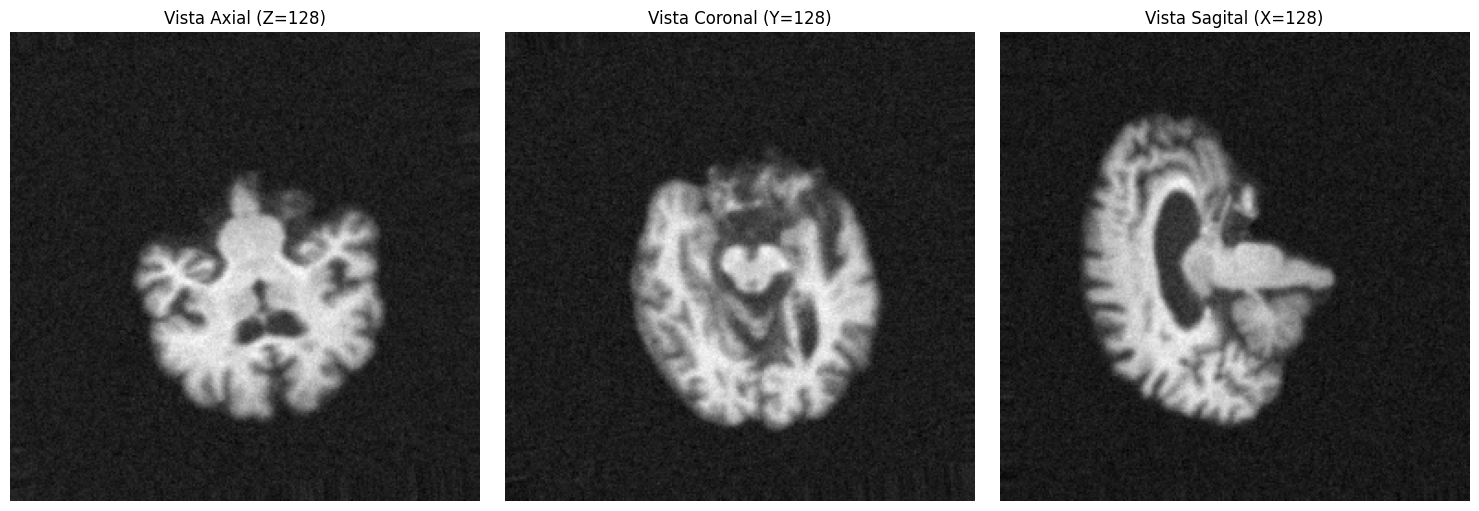

In [102]:
plot_slices(data)

# Stats

In [ ]:
subjects_dir = "/home/nicolas/Documentos/gliara/OASIS/1/" 
subject_id = "OAS1_0005_MR1"

In [ ]:
def extract_stats(subjects_dir,subject_id):
    aseg_stats_path = os.path.join(subjects_dir, subject_id, 'stats', 'aseg.stats')

    try:
        with open(aseg_stats_path, 'r') as f:
            lines = f.readlines()

        header_line_index = -1
        for i, line in enumerate(lines):
            if line.strip().startswith('# ColHeaders'):
                header_line_index = i
                break

        if header_line_index == -1:
            raise ValueError("Could not find '# ColHeaders' in the aseg.stats file. Cannot determine column headers.")

        header_line = lines[header_line_index].replace('# ColHeaders', '', 1).strip()
        column_names_aseg = header_line.split()

        data_start_index = header_line_index + 1
        data_lines_aseg = lines[data_start_index:]

        df_aseg = pd.read_csv(io.StringIO("".join(data_lines_aseg)), delim_whitespace=True, header=None)

        df_aseg.columns = column_names_aseg

        print("\nDataFrame para aseg.stats (primeras 5 filas):")
        print(df_aseg.head())
        print("\nColumnas del DataFrame aseg.stats:")
        print(df_aseg.columns)

    except FileNotFoundError:
        print(f"Error: El archivo aseg.stats no fue encontrado en {aseg_stats_path}. Verifica la ruta o si el FreeSurfer se ejecutó correctamente.")
    except ValueError as ve:
        print(f"Error en el formato de aseg.stats: {ve}")
        print("Revisa el archivo manualmente para entender su formato, especialmente la línea '# ColHeaders'.")
    except Exception as e:
        print(f"Ocurrió un error inesperado al cargar el archivo aseg.stats: {e}")
        print("Por favor, verifica el archivo y los permisos de acceso.")

    print("\n--- Cargando un archivo aparc.stats (ejemplo para hemisferio izquierdo) ---")
    aparc_stats_path = os.path.join(subjects_dir, subject_id, 'stats', 'lh.aparc.stats')

    try:
        df_aparc = None

        with open(aparc_stats_path, 'r') as f:
            lines_aparc = f.readlines()

        header_line_aparc = None
        data_lines_aparc = []
        found_colheaders = False

        for line in lines_aparc:
            if line.strip().startswith('# ColHeaders'):
                header_line_aparc = line.strip('# ColHeaders').strip().split()
                found_colheaders = True
            elif found_colheaders and not line.strip().startswith('#'): 
                data_lines_aparc.append(line)

        if header_line_aparc:
            df_aparc_raw = pd.read_csv(io.StringIO("".join(data_lines_aparc)), delim_whitespace=True, header=None, engine='python')


            if not df_aparc_raw.empty and str(df_aparc_raw.iloc[-1, 0]).strip().upper() == 'TOTAL':
                df_aparc_raw = df_aparc_raw.iloc[:-1]

            if len(header_line_aparc) == df_aparc_raw.shape[1]:
                df_aparc = df_aparc_raw
                df_aparc.columns = header_line_aparc
            else:
                print(f"Advertencia: El número de columnas ({df_aparc_raw.shape[1]}) en {os.path.basename(aparc_stats_path)} no coincide con la cabecera extraída ({len(header_line_aparc)}). Asignando cabeceras genéricas.")
                df_aparc_raw.columns = [f'Col{i}' for i in range(df_aparc_raw.shape[1])]
                df_aparc = df_aparc_raw
        else:
            print(f"Advertencia: No se encontró la línea '# ColHeaders' en {os.path.basename(aparc_stats_path)}. Intentando lectura genérica.")
            df_aparc = pd.read_csv(aparc_stats_path, delim_whitespace=True, comment='#', engine='python')

        print("\nDataFrame para lh.aparc.stats (primeras 5 filas después de limpieza):")
        print(df_aparc.head())
        print("\nColumnas del DataFrame lh.aparc.stats:")
        print(df_aparc.columns)

    except FileNotFoundError:
        print(f"Error: El archivo lh.aparc.stats no fue encontrado en {aparc_stats_path}. Verifica la ruta o si el FreeSurfer se ejecutó correctamente.")
    except Exception as e:
        print(f"Ocurrió un error inesperado al cargar el archivo aparc.stats: {e}")
        print("Revisa el archivo manualmente para entender su formato o si hay problemas de permisos.")
    
    # Guardar los DataFrames como CSV
    df_aseg.to_csv(os.path.join(subjects_dir, subject_id, 'stats', 'aseg_stats.csv'), index=False)
    df_aparc.to_csv(os.path.join(subjects_dir, subject_id, 'stats', 'lh_aparc_stats.csv'), index=False)

    return None

por usar

In [ ]:
for i in crossSectional.index:
    extract_stats(subjects_dir,crossSectional["ID"][i])

# Aumentacion de datos

## Aumentacion de Neuroimagen

In [96]:
def random_rotation_3d(image, max_angle=6):
    angles = [random.uniform(-max_angle, max_angle) for _ in range(3)] # X, Y, Z
    rotated_image = image
    for axis, angle in enumerate(angles):
        rotated_image = ndi.rotate(rotated_image, angle, axes=(axis, (axis + 1) % 3),
                                   reshape=False, order=1, mode='nearest')
    return rotated_image

def random_shift_3d(image, max_shift_pixels=5):
    shift_x = random.randint(-max_shift_pixels, max_shift_pixels)
    shift_y = random.randint(-max_shift_pixels, max_shift_pixels)
    shift_z = random.randint(-max_shift_pixels, max_shift_pixels)
    shifted_image = ndi.shift(image, (shift_x, shift_y, shift_z), order=1, mode='nearest')
    return shifted_image

def random_intensity_scale(image, scale_factor_range=(0.8, 1.2), add_offset_range=(-0.1, 0.1)):
    scale_factor = random.uniform(*scale_factor_range)
    add_offset = random.uniform(*add_offset_range)
    augmented_image = image * scale_factor + add_offset
    return augmented_image

def add_gaussian_noise(image, noise_std_dev=0.01):
    noise = np.random.normal(0, noise_std_dev, image.shape)
    augmented_image = image + noise
    return augmented_image

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if max_val - min_val > 0:
        return (image - min_val) / (max_val - min_val)
    return image 

def apply_augmentations(image):
    image = random_rotation_3d(image, max_angle=10)
    image = random_shift_3d(image, max_shift_pixels=5)
    image = random_intensity_scale(image, scale_factor_range=(0.8, 1.2), add_offset_range=(-0.1, 0.1))
    image = add_gaussian_noise(image, noise_std_dev=0.02)
    return normalize_image(image)

In [97]:
data = apply_augmentations(data)

## Aumentacion de stats

# Generacion de imagenes